<a href="https://colab.research.google.com/github/Akash-088/Brain-Tumor-Detection-/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install split-folders

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.listdir("/content/drive/MyDrive/data")

['Testing', 'Training']

In [6]:
import pathlib
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

training_data_dir = "/content/drive/MyDrive/data/Training"
testing_data_dir = "/content/drive/MyDrive/data/Testing"

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    training_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    testing_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [7]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 4)

    def forward(self, x):
        return self.resnet(x)

model = BrainTumorCNN()

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]

BrainTumorCNN(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size
)

model.save("brain_tumor_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1217s 7s/step - accuracy: 0.5973 - loss: 1.0020 - val_accuracy: 0.8203 - val_loss: 0.4681
Epoch 2/10
  1/178 ━━━━━━━━━━━━━━━━━━━━ 3:14 1s/step - accuracy: 0.8438 - loss: 0.4127

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 136ms/step - accuracy: 0.8438 - loss: 0.4127 - val_accuracy: 0.8133 - val_loss: 0.4637
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.8580 - loss: 0.3869 - val_accuracy: 0.8555 - val_loss: 0.3707
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.9375 - loss: 0.3787 - val_accuracy: 0.8719 - val_loss: 0.3464
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9077 - loss: 0.2638 - val_accuracy: 0.8961 - val_loss: 0.2742
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.8750 - loss: 0.3198 - val_accuracy: 0.8906 - val_loss: 0.2745
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.9393 - loss: 0.1634 - val_accuracy: 0.9336 - val_loss: 0.1735
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 40s 219ms/step - accuracy: 1.0000 - loss: 0.0687 - val_accuracy: 0.9328 - val_loss: 0.1738
Epoch 9/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9486 - loss: 0.1409 - val_accurac

In [10]:
import pathlib

data_dir = pathlib.Path("/content/drive/MyDrive/data")

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.ImageFolder(data_dir / 'Training', transform=transform)
val_set = torchvision.datasets.ImageFolder(data_dir / 'Testing', transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

print("Classes:", train_set.classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
print(train_set)

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /content/drive/MyDrive/data/Training
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


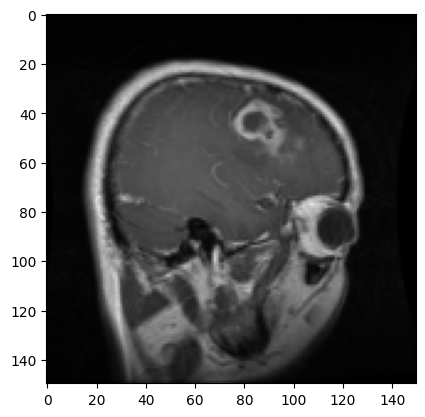

In [12]:
img, label = train_set[1000]
plt.imshow(img.permute(1,2,0))

In [13]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [14]:
next(iter(val_loader))[0].shape

torch.Size([64, 3, 150, 150])

In [15]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.leakyRelu = nn.LeakyReLU()
        self.fc1 = nn.Linear(128 * 5 * 5, 1024)
        self.fc2 = nn.Linear(1024, 4)

    def forward(self, x):
        out = self.leakyRelu(self.cnv1(x))
        out = self.maxpool1(out)

        out = self.leakyRelu(self.cnv2(out))
        out = self.maxpool2(out)

        out = self.leakyRelu(self.cnv3(out))
        out = self.maxpool3(out)

        out = self.leakyRelu(self.cnv4(out))
        out = self.maxpool4(out)

        out = out.view(out.size(0), -1)

        out = self.leakyRelu(self.fc1(out))
        out = self.fc2(out)

        return out

In [16]:
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [17]:
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    outputs = model(images)
    loss = error(outputs, labels)
    train_loss+=loss.item()
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    correct+=(predicted==labels).sum()


  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Acciracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))

Loss in Iteration: 0 : 1.3864244222640991
Loss in Iteration: 1 : 1.3303563594818115
Loss in Iteration: 2 : 1.5493464469909668
Loss in Iteration: 3 : 1.3941361904144287
Loss in Iteration: 4 : 1.3679755926132202
Loss in Iteration: 5 : 1.380672574043274
Loss in Iteration: 6 : 1.3844267129898071
Loss in Iteration: 7 : 1.3746105432510376
Loss in Iteration: 8 : 1.3661444187164307
Loss in Iteration: 9 : 1.3625657558441162
Loss in Iteration: 10 : 1.2963876724243164
Loss in Iteration: 11 : 1.2662676572799683
Loss in Iteration: 12 : 1.265365481376648
Loss in Iteration: 13 : 1.327033281326294
Loss in Iteration: 14 : 1.0693024396896362
Loss in Iteration: 15 : 2.022442579269409
Loss in Iteration: 16 : 1.1036866903305054
Loss in Iteration: 17 : 1.3412505388259888
Loss in Iteration: 18 : 1.4303354024887085
Loss in Iteration: 19 : 1.377868890762329
Loss in Iteration: 20 : 1.3683620691299438
Loss in Iteration: 21 : 1.4051456451416016
Loss in Iteration: 22 : 1.3687483072280884
Loss in Iteration: 23 : 1.

In [18]:
train_loss_list

[0.9659010903702842,
 0.5427110142178005,
 0.43088110900587506,
 0.3247199076745245,
 0.24365510427289538,
 0.19000092405411934,
 0.12701338501647114,
 0.10073954123589728,
 0.07153411750785178,
 0.06535997837781907]

In [19]:
val_loss_list

[0.7055732692990985,
 0.7342055865696498,
 0.5258650226252419,
 0.4019714246193568,
 0.4226581241403307,
 0.22247031047230675,
 0.1769619341052714,
 0.1346254769180502,
 0.19209911745219005,
 0.12383291338171278]

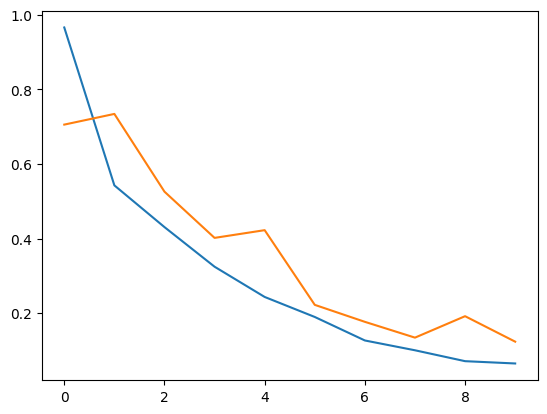

In [20]:
plt.plot(range(num_epochs), train_loss_list)
plt.plot(range(num_epochs), val_loss_list)

In [21]:
accuracy_list

[tensor(69.5652),
 tensor(69.6415),
 tensor(79.0999),
 tensor(83.6003),
 tensor(83.6003),
 tensor(91.6857),
 tensor(92.6773),
 tensor(95.1945),
 tensor(93.5927),
 tensor(95.4996)]

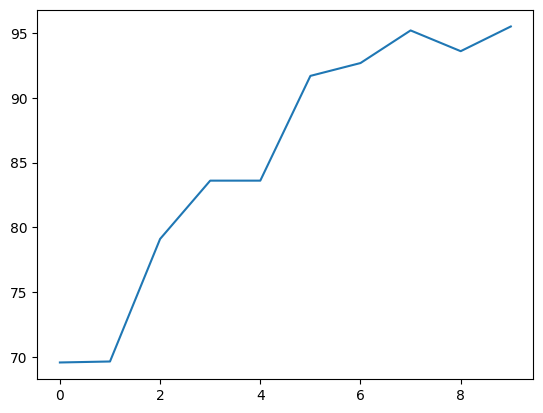

In [22]:
plt.plot(range(num_epochs), accuracy_list)

Text(0.5, 1.0, '1')

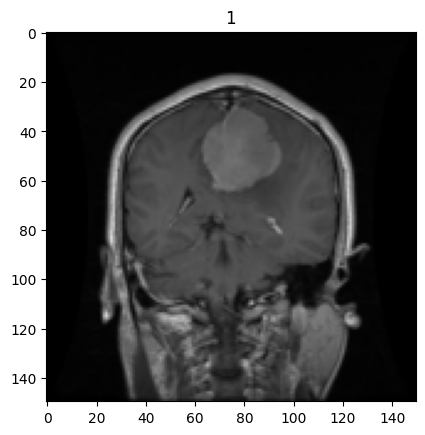

In [34]:
img, label = val_set[500]
plt.imshow(img.permute(1,2,0))
plt.title(label)

In [35]:
image = img.unsqueeze(0)

with torch.no_grad():
  output = model(image)

_, pred = torch.max(output, 1)
print("Predicted Output:", pred.item())

Predicted Output: 1
